In [75]:
import torch
from types import MethodType
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
sentences = ["Apply for Beninese Visas Online.", "Подайте онлайн заяву на візу в Сінгапур."]
device = 'cuda:1'
self = SentenceTransformer('sentence-transformers/LaBSE', device=device).to(device).eval()
self


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 768, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
  (3): Normalize()
)

In [77]:
def tokenize_and_embed(self, sentences):
    """
    Tokenize sentences, move to the right device and ask for gradients for the input embeddings.

    Args:
        sentences List[str]: Sentences to embed
        target_device (torch.device): Device on which the returned tensor(s) should be located.

    Returns:
        dict with keys: input_ids, token_type_ids, attention_mask, input_embeds
    """
    bert = self[0].auto_model
    device = next(bert.parameters()).device

    source_batch = self.tokenize(sentences)
    target_batch = {}
    for key in source_batch:
        if key == 'input_ids':
            input_ids = source_batch[key].to(device)
            target_batch['_input_ids'] = input_ids
            inputs_embeds = bert.embeddings(input_ids=input_ids)
            inputs_embeds = inputs_embeds.detach().requires_grad_(True).to(device)
            inputs_embeds.retain_grad()
            target_batch['inputs_embeds'] = inputs_embeds
        elif isinstance(source_batch[key], torch.Tensor):
            target_batch[key] = source_batch[key].to(device)
        else:
            target_batch[key] = source_batch[key]
    return target_batch

def transformer_forward(self, features):
    """Returns token_embeddings, cls_token"""
    trans_features = {'inputs_embeds': features['inputs_embeds'], 'attention_mask': features['attention_mask']}
    output_states = self.auto_model(**trans_features, return_dict=False)
    output_tokens = output_states[0]

    features.update({'token_embeddings': output_tokens, 'attention_mask': features['attention_mask']})
    return features

self.tokenize_and_embed = MethodType(tokenize_and_embed, self)
self[0].forward = MethodType(transformer_forward, self[0])

In [78]:
input = self.tokenize_and_embed(sentences)
output = self(input)
s = output['sentence_embedding']
output

{'_input_ids': tensor([[   101,  82927,  15014, 120888,  21945,  89491,  16702,    119,    102,
               0,      0,      0,      0,      0,      0],
         [   101,  56470,  49042,  19275, 146917,  14984, 500375,  35990,    699,
             682, 244316,  45948,  32287,    119,    102]], device='cuda:1'),
 'inputs_embeds': tensor([[[-0.1245,  0.0072, -0.1442,  ...,  0.0183, -0.0931, -0.2592],
          [-0.3614,  0.1735,  0.0259,  ..., -0.7336, -0.7668, -0.4192],
          [-0.2231, -0.0392, -0.8699,  ..., -0.2229, -0.1267,  0.3546],
          ...,
          [ 0.3894,  0.2436,  0.9684,  ..., -0.0178, -0.6403, -0.3498],
          [ 0.4163,  0.3073,  0.9847,  ..., -0.0513, -0.6370, -0.3237],
          [ 0.4015,  0.2405,  0.9768,  ..., -0.2452, -0.6511, -0.3500]],
 
         [[-0.1245,  0.0072, -0.1442,  ...,  0.0183, -0.0931, -0.2592],
          [ 0.2273,  0.3690, -0.0186,  ..., -0.0358,  0.0503,  0.5240],
          [-0.0151,  0.4168, -0.2689,  ..., -0.2229, -0.2662,  0.0944],
  

In [79]:
outer = s @ s.T
outer

tensor([[1.0000, 0.6002],
        [0.6002, 1.0000]], device='cuda:1', grad_fn=<MmBackward0>)

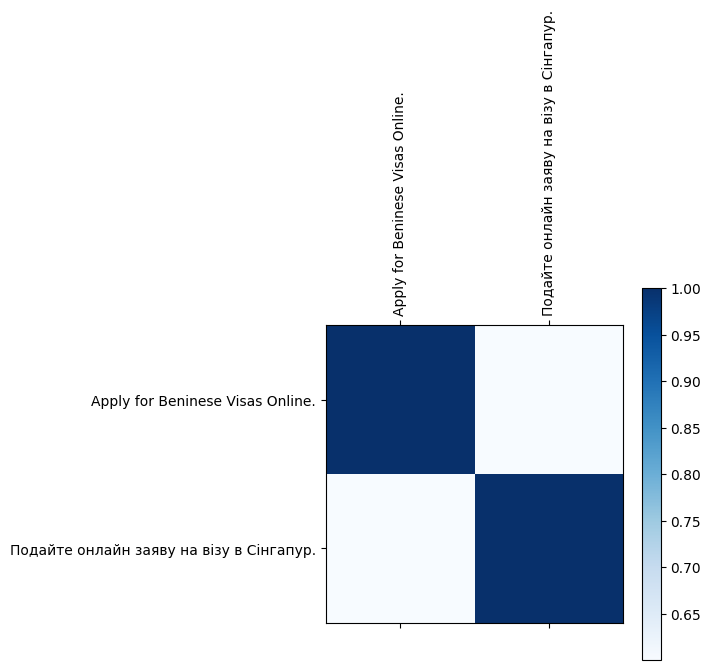

In [80]:
plt.matshow(outer.detach().cpu().numpy(), cmap='Blues')
plt.xticks(range(len(sentences)), sentences, rotation=90)
plt.yticks(range(len(sentences)), sentences, rotation=0)
plt.colorbar();

In [81]:
self.zero_grad()
outer[0,1].backward()

In [93]:
self.tokenizer.convert_ids_to_tokens(input['_input_ids'][i, j].item())

'[CLS]'

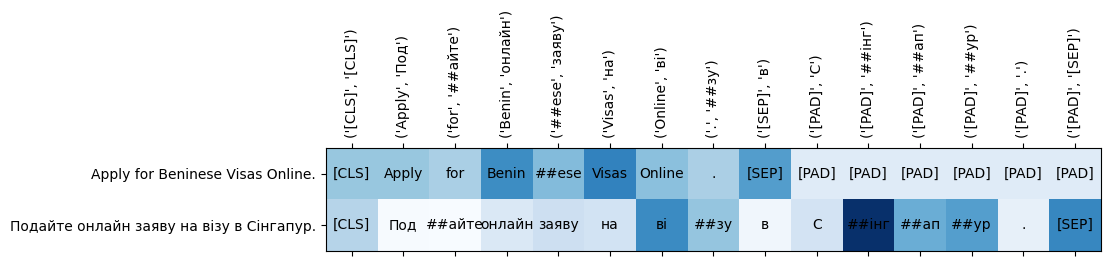

In [135]:
grads = input['inputs_embeds'].grad.square().sum(-1).sqrt().softmax(-1)
#grads = grads / grads.sum(-1, keepdim=True)

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.matshow(grads.detach().cpu().numpy(), cmap='Blues')
ax.set_yticks(range(len(sentences)), sentences, rotation=0)    
ax.set_xticks(
    range(len(input['_input_ids'][0])),
    list(zip(*[self.tokenizer.convert_ids_to_tokens(x) for x in input['_input_ids'].tolist()])),
    rotation=90
)

for i in range(len(sentences)):
    for j in range(len(input['_input_ids'][0])):
        text = ax.text(j, i, self.tokenizer.convert_ids_to_tokens(input['_input_ids'][i, j].item()),
                       ha="center", va="center", color="k")

#plt.colorbar(im, ax=ax);

In [136]:
for input_ids in input['_input_ids'].tolist():
    print(self.tokenizer.convert_ids_to_tokens(input_ids))

['[CLS]', 'Apply', 'for', 'Benin', '##ese', 'Visas', 'Online', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'Под', '##айте', 'онлайн', 'заяву', 'на', 'ві', '##зу', 'в', 'С', '##інг', '##ап', '##ур', '.', '[SEP]']
